# About

I will also do holdout benchmarking for the Survival models. The holdout period will also be 30 days.

It means I cut off 30 days from all available data, train and inference on that data, then evaluate against the truth 30 days later.

# Preparation

## Libraries

In [1]:
import pandas as pd
import numpy as np

In [165]:
from dotenv import load_dotenv
import os
from pathlib import Path
import joblib

In [3]:
from scipy import stats

In [4]:
from src.core.transforms import (
    transform_transactions_df,
    transform_customers_df,
    get_customers_screenshot_summary_from_transactions_df,
    add_churn_status
)

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [6]:
from lifelines import CoxPHFitter, WeibullAFTFitter

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    average_precision_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

In [65]:
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
from itertools import product

In [127]:
import mlflow

In [168]:
import cloudpickle

In [180]:
import traceback

In [ ]:
import tempfile

## Environment

In [9]:
load_dotenv()

True

In [10]:
PROJECT_ROOT = Path.cwd().parent

In [11]:
MAX_DATA_DATE = pd.Timestamp('2025-12-31')
MAX_DATA_DATE_STR = MAX_DATA_DATE.strftime("%d_%m_%Y")
CUTOFF_DATE = MAX_DATA_DATE - pd.Timedelta(days=30)

In [12]:
BASE_GOLD_DIR = PROJECT_ROOT / "data" / "gold" / MAX_DATA_DATE_STR

In [13]:
MLRUNS_DIR = PROJECT_ROOT / "mlruns"

In [14]:
SEED_CUSTOMERS=os.getenv("SEED_CUSTOMERS")
SEED_TRANSACTIONS=os.getenv("SEED_TRANSACTIONS")

In [15]:
targets = ['is_churn_30_days']

In [230]:
MLRUNS_DIR = PROJECT_ROOT / "mlruns"
EXPERIMENT_NAME = "customer_lifetime_modeling"
mlflow.set_tracking_uri(f"file://{MLRUNS_DIR}")
from mlflow.tracking import MlflowClient

client = MlflowClient()

## 02 Notebook Wrappers

### Feature Engineering

In [16]:
def get_rfm_window_features(customers_df, transactions_df, observed_date):

    rfm_time_windows = ["all_time", "30d", "60d", "90d"]

    for rfm_time_window in rfm_time_windows:

        if rfm_time_window == "all_time":
            filtered_transactions_df = transactions_df
        else:
            # Limit data to the new cutoff
            days = int(rfm_time_window.strip("d"))
            filtered_transactions_df = transactions_df[
                (transactions_df['transaction_date'] <= observed_date - pd.Timedelta(days=days))
            ]

        # Get a Customers Screenshot Summary DataFrame. It has RFM features and other variables that RFM features depend on.
        summary_modeling_df = get_customers_screenshot_summary_from_transactions_df(
            transactions_df=filtered_transactions_df,
            observed_date=observed_date,
            column_names=["customer_id", "transaction_date", "amount"]
        )

        # Keep only customer_id and the RFM columns we care about
        summary_modeling_df = summary_modeling_df[[
            'customer_id',
            'days_until_observed',
            'period_transaction_count',
            'period_total_amount',
            'period_tenure_days'
        ]]

        # Rename columns in the summary DF, not the main DF
        summary_modeling_df = summary_modeling_df.rename(columns={
            'days_until_observed': f'rfm_recency_{rfm_time_window}',
            'period_transaction_count': f'rfm_frequency_{rfm_time_window}',
            'period_total_amount': f'rfm_monetary_{rfm_time_window}',
            'period_tenure_days': f'tenure_{rfm_time_window}'
        })
        
        # Merge with current data used for modelling.
        customers_df = pd.merge(
            customers_df,
            summary_modeling_df,
            on="customer_id",
            how="left"
        )

    return customers_df

In [17]:
def get_slope_features(customers_df, transactions_df, observed_date, feature_list):

    time_windows = ["all_time", "30d", "60d", "90d"]

    for time_window in time_windows:

        if time_window == "all_time":
            filtered_transactions_df = transactions_df
        else:
            # Limit data to the new cutoff
            days = int(time_window.strip("d"))
            filtered_transactions_df = transactions_df[
                (transactions_df['transaction_date'] <= observed_date - pd.Timedelta(days=days))
            ]

    customers_list = filtered_transactions_df['customer_id'].unique()

    slopes = {}

    for customer_id in customers_list:

        customer_transactions = filtered_transactions_df[filtered_transactions_df['customer_id'] == customer_id]

        x = np.arange(len(customer_transactions)) #time axis
        slopes[customer_id] = {} #initiate value list

        for feature_name in feature_list:
            y = customer_transactions[feature_name].values
            x_valid = x[~np.isnan(y)]
            y_valid = y[~np.isnan(y)]

            if len(y_valid) < 2:
                slopes[customer_id][feature_name] = np.nan
            else:
                slope = np.polyfit(x_valid, y_valid, 1)[0]
                slopes[customer_id][feature_name] = slope

    # Convert dict of dicts into dataframe
    slope_features_df = pd.DataFrame.from_dict(slopes, orient='index')

    # Rename columns to have slope_ prefix
    slope_features_df = slope_features_df.rename(columns={f: f'slope_{f}' for f in slope_features_df.columns})

    # Reset index to have customer_id as a column
    slope_features_df = slope_features_df.reset_index().rename(columns={'index': 'customer_id'})

    # Merge with current data used for modelling.
    customers_df = pd.merge(
        customers_df,
        slope_features_df,
        on="customer_id",
        how="left"
    )

    return customers_df

In [18]:
def get_transaction_statistics_features(customers_df, transactions_df, observed_date, feature_list):

    time_windows = ["all_time", "30d", "60d", "90d"]

    all_stats_df_list = []

    for time_window in time_windows:

        if time_window == "all_time":
            filtered_transactions_df = transactions_df
        else:
            # Limit data to the new cutoff
            days = int(time_window.strip("d"))
            filtered_transactions_df = transactions_df[
                (transactions_df['transaction_date'] <= observed_date - pd.Timedelta(days=days))
            ]

        customers_list = filtered_transactions_df['customer_id'].unique()
        stats_dict = {}

        for customer_id in customers_list:

            customer_transactions = filtered_transactions_df[
                filtered_transactions_df['customer_id'] == customer_id
            ]

            stats_dict[customer_id] = {}

            for feature_name in feature_list:

                y = customer_transactions[feature_name].dropna().values

                if len(y) < 2:
                    # Less than 2 observations -> return NaN for all stats
                    stats_dict[customer_id][f"min_{feature_name}"] = np.nan
                    stats_dict[customer_id][f"mean_{feature_name}"] = np.nan
                    stats_dict[customer_id][f"mode_{feature_name}"] = np.nan
                    stats_dict[customer_id][f"max_{feature_name}"] = np.nan
                    for q in [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]:
                        stats_dict[customer_id][f"q{q}_{feature_name}"] = np.nan
                    continue

                # Compute stats
                stats_dict[customer_id][f"min_{feature_name}"] = np.min(y)
                stats_dict[customer_id][f"mean_{feature_name}"] = np.mean(y)

                # Compute mode safely
                mode_result = stats.mode(y, nan_policy='omit')
                if hasattr(mode_result.mode, "__len__"):
                    # old SciPy: mode is array
                    mode_val = mode_result.mode[0] if len(mode_result.mode) > 0 else np.nan
                else:
                    # new SciPy: mode is scalar
                    mode_val = mode_result.mode if mode_result.count > 0 else np.nan

                stats_dict[customer_id][f"mode_{feature_name}"] = mode_val

                stats_dict[customer_id][f"max_{feature_name}"] = np.max(y)

                # Quantiles
                for q in [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]:
                    stats_dict[customer_id][f"q{q}_{feature_name}"] = np.percentile(y, q)

        # Convert to dataframe
        stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').reset_index().rename(columns={'index': 'customer_id'})
        all_stats_df_list.append(stats_df)

    # Merge with customers_df (only keep last time_window stats)
    final_stats_df = all_stats_df_list[-1]  # or merge all windows if needed
    customers_df = pd.merge(customers_df, final_stats_df, on='customer_id', how='left')

    return customers_df

In [19]:
def build_training_base(
    seed_customers_path,
    seed_transactions_path,
    train_snapshot_date,
    churn_windows=[30, 60, 90],
):
    """
    Reads raw data, transforms it, limits it to modeling window,
    builds customer modeling table, and adds churn labels.
    """

    # --- Read data ---
    customers_df = pd.read_csv(seed_customers_path)
    transactions_df = pd.read_csv(seed_transactions_path)

    # --- Transform data ---
    transactions_df = transform_transactions_df(transactions_df)
    customers_df = transform_customers_df(customers_df)

    # --- Derive MAX_DATA_DATE internally ---
    max_data_date = transactions_df["transaction_date"].max()

    # --- Limit transactions to snapshot ---
    transactions_modeling_df = transactions_df.loc[
        transactions_df["transaction_date"] <= train_snapshot_date
    ]

    # --- Build customer modeling base ---
    customers_modeling_df = (
        pd.DataFrame({
            "customer_id": transactions_modeling_df["customer_id"].unique()
        })
        .merge(customers_df, on="customer_id", how="inner")
        .drop(columns=["signup_date", "true_lifetime_days", "termination_date"])
    )

    # --- Add churn labels ---
    for nday in churn_windows:
        var_name = f"is_churn_{nday}_days"
        observed_date = max_data_date - pd.Timedelta(days=nday)

        customers_modeling_df = add_churn_status(
            transformed_customers_df=customers_df,
            observed_date=observed_date,
            desired_df=None,
        )

        customers_modeling_df = customers_modeling_df.rename(columns={'is_churn': var_name})

    return transactions_modeling_df, customers_modeling_df

### Helpers

In [20]:
def check_nan_in_df_cols(df):
    # Get relative percentage of nulls by column
    null_features_proportion = (
        df.isna().sum() / len(df)
    ).sort_values(ascending=False)

    high_proportion = []
    medium_proportion = []
    low_proportion = []

    for feature, proportion in null_features_proportion.items():
        if proportion >= 0.20:
            high_proportion.append(feature)
        elif 0.05 <= proportion < 0.20:
            medium_proportion.append(feature)
        else:
            low_proportion.append(feature)

    # Build features DataFrame
    features_df = null_features_proportion.reset_index()
    features_df.columns = ["feature", "nan_proportion"]

    features_df["NaN group"] = features_df["feature"].apply(
        lambda f: (
            "High" if f in high_proportion
            else "Medium" if f in medium_proportion
            else "Low"
        )
    )

    # Print counts (same behavior as before)
    print("Total features:", len(df.columns))
    print("Information on NaN values")
    print("====================================")
    print("Number of High Proportion Features:", len(high_proportion))
    print("Number of Medium Proportion Features:", len(medium_proportion))
    print("Number of Low Proportion Features:", len(low_proportion))

    return features_df


In [21]:
def save_X_csv(X_by_target, BASE_GOLD_DIR):

    for target in X_by_target.keys():

        target_dir = BASE_GOLD_DIR / target
        target_dir.mkdir(parents=True, exist_ok=True)

        X_by_target[target].to_csv(
            target_dir / "X_train.csv",
            index=True,
        )

        print(f"[{target}] written to {target_dir}")
    
    return "All data saved successfully."

In [22]:
def save_y_csv(
        X_by_target,
        y,
        BASE_GOLD_DIR
    ):

    for target in targets:
        target_dir = BASE_GOLD_DIR / target
        target_dir.mkdir(parents=True, exist_ok=True)

        # ----------------------------
        # TRAIN labels
        # ----------------------------
        y.loc[
            X_by_target[target].index, target
        ].to_csv(
            target_dir / "y_train.csv",
            header=True,
        )
    
    return "All data saved successfully."

In [23]:
def save_raw_features_csv(df, split, base_gold_dir, index_name='customer_id'):
    path = Path(base_gold_dir) / "raw"
    path.mkdir(parents=True, exist_ok=True)

    print("WRITING TO:", path.resolve())

    df.index.name = index_name
    df.to_csv(
        path / f"{split}_features.csv",
        index=True, # keep customer_id
    )

In [24]:
def save_transformed_by_target_csv(X_by_target, split, base_gold_dir, index_name='customer_id'):

    for target, df in X_by_target.items():
        
        base_path = Path(base_gold_dir) / "transformed" / target
        base_path.mkdir(parents=True, exist_ok=True)

        df.index.name = index_name
        df.to_csv(
            base_path / f"X_{split}.csv",
            index=True,  # keep customer_id
        )

In [25]:
def load_transformed(BASE_GOLD_DIR, split, target):
    return pd.read_csv(
        BASE_GOLD_DIR / "transformed" / target / f"X_{split}.csv",
        index_col=0,
    )

### Feature Transformation

In [26]:
def mutual_information_feature_selection(
    X_train,
    y_train,
    target,
    cutoff=0.0,
    random_state=42
):
    """
    Perform mutual information–based feature selection for a given target.

    Returns:
        selected_df: DataFrame with selected features
        mi_scores: DataFrame with MI scores per feature
        selected_features: Index of selected feature names
    """

    assert X_train.index.equals(y_train.index)

    mi_train = mutual_info_classif(
        X_train,
        y_train[target],
        random_state=random_state
    )

    mi_scores = (
        pd.DataFrame(
            mi_train,
            index=X_train.columns,
            columns=["mutual_info"]
        )
        .sort_values(by="mutual_info", ascending=False)
    )

    selected_features = mi_scores.loc[
        mi_scores["mutual_info"] > cutoff
    ].index

    selected_df = X_train[selected_features]

    return selected_df, mi_scores, selected_features

### Feature Processing Pipeline

In [27]:
def add_transaction_time_features(transactions_df):
    """
    Add time-based and order-based transaction features.

    Parameters
    ----------
    transactions_df : pd.DataFrame
        Must contain: customer_id, transaction_date

    Returns
    -------
    pd.DataFrame
        Copy of transactions_df with added features
    """

    df = transactions_df.sort_values(
        ["customer_id", "transaction_date"]
    ).copy()

    df["customer_transaction_order"] = (
        df.groupby("customer_id").cumcount()
    )

    df["prev_transaction_date"] = (
        df.groupby("customer_id")["transaction_date"].shift(1)
    )

    df["next_transaction_date"] = (
        df.groupby("customer_id")["transaction_date"].shift(-1)
    )

    df["days_since_previous_transaction"] = (
        df["transaction_date"] - df["prev_transaction_date"]
    ).dt.days

    df["days_until_next_transaction"] = (
        df["next_transaction_date"] - df["transaction_date"]
    ).dt.days

    df["first_transaction_date"] = (
        df.groupby("customer_id")["transaction_date"]
        .transform("min")
    )

    df["days_since_first_transaction"] = (
        df["transaction_date"] - df["first_transaction_date"]
    ).dt.days

    return df

In [28]:
def build_customer_features(
    transactions_modeling_df,
    customers_modeling_df,
    observed_date,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ],
):
    """
    Build raw customer-level features from transactions and customers data.
    No imputing, scaling, or selection is performed here.
    """

    # 1. Transaction-level features
    transactions_df = add_transaction_time_features(
        transactions_modeling_df
    )

    # 2. RFM window features
    customers_df = get_rfm_window_features(
        customers_df=customers_modeling_df,
        transactions_df=transactions_df,
        observed_date=observed_date,
    )

    # 3. Activity trend (slopes)
    customers_df = get_slope_features(
        customers_df=customers_df,
        transactions_df=transactions_df,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    # 4. Transaction statistics
    customers_df = get_transaction_statistics_features(
        customers_df=customers_df,
        transactions_df=transactions_df,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    return customers_df

In [29]:
def fit_numeric_transformers(
    X_train_numeric_df,
    imputer_params=None,
    scaler_params=None,
):
    """
    Fit numeric imputer and scaler on training data only.

    Returns
    -------
    X_train_numeric_imputed_scaled_df : pd.DataFrame
    numeric_imputer : fitted IterativeImputer
    scaler : fitted StandardScaler
    """

    # -------------------------------
    # Defaults
    # -------------------------------
    if imputer_params is None:
        imputer_params = dict(
            estimator=LinearRegression(),
            max_iter=20,
            random_state=42,
        )

    if scaler_params is None:
        scaler_params = {}

    # -------------------------------
    # Imputation (FIT)
    # -------------------------------
    numeric_imputer = IterativeImputer(**imputer_params)
    X_train_numeric_imputed = numeric_imputer.fit_transform(X_train_numeric_df)

    X_train_numeric_imputed_df = pd.DataFrame(
        X_train_numeric_imputed,
        columns=X_train_numeric_df.columns,
        index=X_train_numeric_df.index,
    )

    # -------------------------------
    # Scaling (FIT)
    # -------------------------------
    scaler = StandardScaler(**scaler_params)
    X_train_numeric_imputed_scaled = scaler.fit_transform(
        X_train_numeric_imputed_df
    )

    X_train_numeric_imputed_scaled_df = pd.DataFrame(
        X_train_numeric_imputed_scaled,
        columns=X_train_numeric_df.columns,
        index=X_train_numeric_df.index,
    )

    return (
        numeric_imputer,
        scaler,
    )

In [30]:
def transform_customers_numeric_features(
    X_numeric,
    numeric_imputer,
    scaler,
):
    """
    Apply fitted numeric imputer and scaler.
    """

    X_numeric_imputed = numeric_imputer.transform(X_numeric)
    X_numeric_imputed_df = pd.DataFrame(
        X_numeric_imputed,
        columns=X_numeric.columns,
        index=X_numeric.index,
    )

    X_numeric_scaled = scaler.transform(X_numeric_imputed_df)
    X_numeric_scaled_df = pd.DataFrame(
        X_numeric_scaled,
        columns=X_numeric.columns,
        index=X_numeric.index,
    )

    return X_numeric_scaled_df


In [31]:
def select_features_per_target(
    X_train_transformed_df,
    y_train,
    targets,
    artifact_dir=None,
    cutoff=0.0,
    random_state=42,
):
    """
    Perform feature selection per target using mutual information.
    """

    assert X_train_transformed_df.index.equals(y_train.index), (
        "X_train and y_train must be index-aligned"
    )

    X_train_by_target = {}
    selected_features_by_target = {}
    mi_scores_by_target = {}

    for target in targets:
        X_selected_df, mi_scores, selected_features = (
            mutual_information_feature_selection(
                X_train=X_train_transformed_df,
                y_train=y_train,
                target=target,
                cutoff=cutoff,
                random_state=random_state,
            )
        )

        if artifact_dir is not None:
            with open(
                artifact_dir / f"selected_features_{target}.json",
                "w",
            ) as f:
                json.dump(list(selected_features), f)

        X_train_by_target[target] = X_selected_df
        selected_features_by_target[target] = list(selected_features)
        mi_scores_by_target[target] = mi_scores

        print(f"[{target}] selected {len(selected_features)} features")

    return (
        X_train_by_target,
        selected_features_by_target,
        mi_scores_by_target,
    )

In [32]:
def get_features_per_target(
    X_transformed_df,
    selected_features_by_target
):
    """
    Perform feature selection per target using mutual information.
    """

    X_by_target = {}

    for target, selected_features in selected_features_by_target.items():

        missing_features = set(selected_features) - set(
            X_transformed_df.columns
        )
        if missing_features:
            raise ValueError(
                f"Missing selected features at inference time: {missing_features}"
            )

        X_selected_features = X_transformed_df[selected_features]
        X_by_target[target] = X_selected_features

    return X_by_target

In [33]:
def split_train_test_val(
    customers_modeling_df,
    targets,
    test_size=0.33,
    val_size=0.33,
    random_state=42,
):
    """
    Split customer modeling dataframe into train / val / test sets.

    Parameters
    ----------
    customers_modeling_df : pd.DataFrame
        Must contain customer_id and target columns.
    targets : list[str]
        Target column names.
    test_size : float
        Proportion of data used for test+val split.
    val_size : float
        Proportion of test split used for validation.
    random_state : int

    Returns
    -------
    X_train, X_val, X_test, y_train, y_val, y_test
    """

    # -------------------------------
    # Feature / target separation
    # -------------------------------
    X_df = customers_modeling_df.drop(columns=targets)
    X_df = X_df.set_index("customer_id", drop=True)

    y_df = customers_modeling_df[["customer_id"] + targets]
    y_df = y_df.set_index("customer_id", drop=True)

    # -------------------------------
    # Train / temp split
    # -------------------------------
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_df,
        y_df,
        test_size=test_size,
        random_state=random_state,
    )

    # -------------------------------
    # Test / validation split
    # -------------------------------
    X_test, X_val, y_test, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=val_size,
        random_state=random_state,
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [34]:
def build_and_transform_customer_features_pipeline_train(
    transactions_modeling_df,
    X_train,
    y_train,
    observed_date,
    targets,
    ARTIFACT_DIR=None,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ],
):
    """
    End-to-end pipeline for TRAIN data.
    """

    # --------------------------------------------------
    # 1. Build raw customer features
    # --------------------------------------------------
    X_train_raw_features_df = build_customer_features(
        transactions_modeling_df=transactions_modeling_df,
        customers_modeling_df=X_train,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    # --------------------------------------------------
    # 2. Numeric transform (impute + scale)
    # --------------------------------------------------
    X_train_raw_features_df = X_train_raw_features_df.set_index("customer_id", drop=False)
    X_train_raw_features_numeric_df = X_train_raw_features_df.select_dtypes(include="number")

    numeric_imputer, scaler = fit_numeric_transformers(
        X_train_raw_features_numeric_df,
        imputer_params=None,
        scaler_params=None,
    )

    X_train_transformed_df = transform_customers_numeric_features(
        X_train_raw_features_numeric_df,
        numeric_imputer,
        scaler,
    )

    # --------------------------------------------------
    # 3. Feature selection per target (EXTRACTED)
    # --------------------------------------------------
    (
        X_train_by_target,
        selected_features_by_target,
        mi_scores_by_target,
    ) = select_features_per_target(
        X_train_transformed_df=X_train_transformed_df,
        y_train=y_train,
        targets=targets,
        artifact_dir=ARTIFACT_DIR,
    )

    # --------------------------------------------------
    # 4. Save transformers ONCE
    # --------------------------------------------------
    if ARTIFACT_DIR is not None:
        joblib.dump(
            numeric_imputer,
            ARTIFACT_DIR / "numeric_imputer.joblib",
        )
        joblib.dump(
            scaler,
            ARTIFACT_DIR / "scaler.joblib",
        )

    X_train_raw_features_df = X_train_raw_features_df.drop(columns=['customer_id'])

    return (
        X_train_raw_features_df,
        X_train_by_target,
        selected_features_by_target,
        mi_scores_by_target,
        numeric_imputer,
        scaler,
    )

In [35]:
def build_and_transform_customer_features_pipeline_test(
    transactions_modeling_df,
    X_test,
    observed_date,
    numeric_imputer,
    scaler,
    selected_features,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ],
):
    """
    End-to-end pipeline for TEST / VAL / INFERENCE data.

    Steps
    -----
    1. Build raw customer-level features from transactions
    2. Remove customer_id from feature space
    3. Apply fitted numeric transformations (imputer + scaler)
    4. Select precomputed feature subset (STRICT reuse)
    """

    # --------------------------------------------------
    # 1. Build raw customer features
    # --------------------------------------------------
    X_test_features_df = build_customer_features(
        transactions_modeling_df=transactions_modeling_df,
        customers_modeling_df=X_test,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    # --------------------------------------------------
    # 2. Set customer_id as index and REMOVE from features
    # --------------------------------------------------
    if "customer_id" not in X_test_features_df.columns:
        raise ValueError("customer_id column missing after feature building")

    X_test_features_df = X_test_features_df.set_index("customer_id", drop=True)

    # --------------------------------------------------
    # 3. Select numeric features and enforce column order
    # --------------------------------------------------
    X_test_numeric_features_df = X_test_features_df.select_dtypes(include="number")

    # Enforce training-time column order (critical for IterativeImputer)
    X_test_numeric_features_df = X_test_numeric_features_df[
        numeric_imputer.feature_names_in_
    ]

    # --------------------------------------------------
    # 4. Apply fitted numeric transformations (NO FIT)
    # --------------------------------------------------
    X_test_numeric_features_transformed_df = transform_customers_numeric_features(
        X_test_numeric_features_df,
        numeric_imputer,
        scaler,
    )

    # --------------------------------------------------
    # 5. Feature selection (STRICT reuse)
    # --------------------------------------------------
    missing_features = set(selected_features) - set(
        X_test_numeric_features_transformed_df.columns
    )
    if missing_features:
        raise ValueError(
            f"Missing selected features at inference time: {missing_features}"
        )

    X_test_final_df = X_test_numeric_features_transformed_df[selected_features]

    return X_test_final_df

In [36]:
def transform_and_select_for_multiple_targets_test(
    X_test_raw_features_df,
    numeric_imputer,
    scaler,
    selected_features_by_target
):
    """
    Build and transform customer features for multiple targets
    (test / val / inference).

    Returns
    -------
    X_by_target : dict[str, pd.DataFrame]
    """

    X_by_target = {}

    # Select numeric features and enforce column order
    X_test_numeric_features_df = X_test_raw_features_df.select_dtypes(include="number")

    # Enforce training-time column order (critical for IterativeImputer)
    X_test_numeric_features_df = X_test_numeric_features_df[
        numeric_imputer.feature_names_in_
    ]

    X_test_transformed_df = transform_customers_numeric_features(
        X_test_numeric_features_df,
        numeric_imputer,
        scaler,
    )

    X_by_target = get_features_per_target(
        X_test_transformed_df,
        selected_features_by_target
    )

    return X_by_target

In [37]:
def build_and_transform_for_multiple_targets(
    transactions_modeling_df,
    X_df,
    observed_date,
    numeric_imputer,
    scaler,
    selected_features_by_target,
):
    """
    Build and transform customer features for multiple targets
    (test / val / inference).

    Returns
    -------
    X_by_target : dict[str, pd.DataFrame]
    """

    X_by_target = {}

    for target, selected_features in selected_features_by_target.items():
        X_by_target[target] = build_and_transform_customer_features_pipeline_test(
            transactions_modeling_df=transactions_modeling_df,
            X_test=X_df,
            observed_date=observed_date,
            numeric_imputer=numeric_imputer,
            scaler=scaler,
            selected_features=selected_features,
            feature_list=[
                "amount",
                "days_since_previous_transaction",
                "days_until_next_transaction",
                "customer_transaction_order",
                "days_since_first_transaction",
            ],
        )

    return X_by_target

### Model

In [38]:
def plot_lgb_feature_importance(
    model,
    importance_type="gain",   # "gain" or "split"
    normalize=False,
    top_n=None,
    title=None,
    height=600,
    as_percent=True
):
    """
    Plot LightGBM feature importance for sklearn API models.
    """

    # --- Extract feature names ---
    if hasattr(model, "feature_name_"):
        features = model.feature_name_
    else:
        raise ValueError("Model does not contain feature names")

    # --- Extract importance correctly ---
    if importance_type == "split":
        importance = model.feature_importances_
    elif importance_type == "gain":
        importance = model.booster_.feature_importance(importance_type="gain")
    else:
        raise ValueError("importance_type must be 'gain' or 'split'")

    df = pd.DataFrame({
        "feature": features,
        "importance": importance
    })

    # Remove zero-importance features
    df = df[df["importance"] > 0]

    # --- Normalize if requested ---
    if normalize:
        total = df["importance"].sum()
        df["importance"] = df["importance"] / total
        if as_percent:
            df["importance"] *= 100
            importance_label = "Normalized Gain (%)"
            text_fmt = ".2f"
        else:
            importance_label = "Normalized Gain"
            text_fmt = ".4f"
    else:
        importance_label = (
            "Gain" if importance_type == "gain" else "Split Count"
        )
        text_fmt = ".2f"

    # Sort and keep top N
    df = df.sort_values("importance", ascending=False)
    if top_n is not None:
        df = df.head(top_n)

    # Reverse for horizontal bar chart
    df = df.sort_values("importance", ascending=True)

    if title is None:
        norm_tag = " (Normalized)" if normalize else ""
        title = f"LightGBM Feature Importance ({importance_type.capitalize()}){norm_tag}"

    fig = px.bar(
        df,
        x="importance",
        y="feature",
        orientation="h",
        title=title,
        labels={
            "importance": importance_label,
            "feature": "Feature"
        },
        text=df["importance"]
    )

    fig.update_traces(
        texttemplate=f"%{{text:{text_fmt}}}",
        textposition="outside",
        cliponaxis=False
    )

    fig.update_layout(
        height=height,
        yaxis=dict(categoryorder="total ascending"),
        margin=dict(r=120)
    )

    fig.show()

In [39]:
def evaluate_binary_model(model, X, y, threshold=0.5):
    """
    Evaluate a binary classifier.
    """

    y_proba = model.predict(X, num_iteration=model.best_iteration_)
    y_pred = (y_proba >= threshold).astype(int)

    metrics = {
        "roc_auc": roc_auc_score(y, y_proba),
        "pr_auc": average_precision_score(y, y_proba),
        "confusion_matrix": confusion_matrix(y, y_pred)
    }

    return metrics

In [40]:
def show_styled_df_confusion_matrix(cm):

    cm_df = pd.DataFrame(
        cm,
        index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"]
    )

    styled_df = (
        cm_df.style
        .background_gradient(cmap="Blues")
        .format("{:.0f}")
    )
    
    return styled_df

In [41]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, X_val, y_val, threshold=0.5):
    """
    Evaluate a binary classifier on train, validation, and test sets.
    Prints:
    - ROC-AUC
    - PR-AUC (Precision–Recall)
    - Accuracy
    - Confusion Matrix
    - Classification Report
    """
    print(f"\n===== {name} =====")

    for split_name, X, y in [
        ("TRAIN", X_train, y_train),
        ("TEST", X_test, y_test),
        ("VALIDATION", X_val, y_val),
    ]:
        # Predicted probabilities and labels
        y_proba = model.predict_proba(X)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)

        # Metrics
        roc_auc = roc_auc_score(y, y_proba)
        pr_auc = average_precision_score(y, y_proba)
        acc = accuracy_score(y, y_pred)
        cm = confusion_matrix(y, y_pred)
        cm_df = pd.DataFrame(
            cm,
            index=["Actual 0", "Actual 1"],
            columns=["Predicted 0", "Predicted 1"]
        )

        # Print results
        print(f"\n{split_name}")
        print("-" * len(split_name))
        print(f"ROC-AUC:      {roc_auc:.4f}")
        print(f"PR-AUC:       {pr_auc:.4f}")
        print(f"Accuracy:     {acc:.4f}")
        print("\nConfusion Matrix:")
        print(cm_df)
        print("\nClassification Report:")
        print(classification_report(y, y_pred))

In [42]:
def train_lgbm(
    X_train,
    y_train,
    X_val,
    y_val,
    target,
    dataset_version,
):
    param_grid = {
        "num_leaves": [31, 63],
        "learning_rate": [0.05, 0.1],
        "n_estimators": [200, 400],
        "max_depth": [-1, 6],
    }

    model = LGBMClassifier(
        objective="binary",
        random_state=42,
        n_jobs=-1,
    )

    grid = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring="average_precision",
        cv=3,
        verbose=0,
    )

    grid.fit(X_train, y_train[target])

    best_model = grid.best_estimator_

    # ---------- Validation predictions ----------
    val_proba = best_model.predict_proba(X_val)[:, 1]
    val_pred = (val_proba >= 0.5).astype(int)  # explicit threshold

    # ---------- Metrics ----------
    roc_auc = roc_auc_score(y_val[target], val_proba)
    pr_auc = average_precision_score(y_val[target], val_proba)
    precision = precision_score(y_val[target], val_pred)
    recall = recall_score(y_val[target], val_pred)

    cm = confusion_matrix(y_val[target], val_pred)
    cm_df = pd.DataFrame(
        cm,
        index=["actual_0", "actual_1"],
        columns=["pred_0", "pred_1"],
    )

    # ---------- MLflow ----------
    input_example = X_train.iloc[:5]
    signature = infer_signature(
        X_train,
        best_model.predict_proba(X_train)[:, 1],
    )

    mlflow.log_param("dataset_version", dataset_version)
    mlflow.log_param("target", target)
    mlflow.log_params(grid.best_params_)

    mlflow.log_metric("val_roc_auc", roc_auc)
    mlflow.log_metric("val_pr_auc", pr_auc)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)

    mlflow.log_text(
        cm_df.to_string(),
        artifact_file=f"confusion_matrix/{dataset_version}_{target}.txt",
    )

    mlflow.lightgbm.log_model(
        best_model,
        name=f"{dataset_version}_{target}",
        input_example=input_example,
        signature=signature,
    )

### Inference

In [43]:
def promote_to_production(run_id):
    client.set_tag(run_id, "stage", "production")

In [44]:
def get_production_runs():
    return mlflow.search_runs(
        filter_string="tags.stage = 'production'",
        search_all_experiments=True,
        output_format="pandas",
    )

    return runs

In [45]:
def load_production_models():
    prod_runs = get_production_runs()

    models = {}
    metadata = {}

    for _, row in prod_runs.iterrows():
        target = row["params.target"]
        dataset_version = row["params.dataset_version"]
        run_id = row["run_id"]

        model_uri = f"runs:/{run_id}/{dataset_version}_{target}"
        model = mlflow.lightgbm.load_model(model_uri)

        models[target] = model
        metadata[target] = {
            "dataset_version": dataset_version,
            "run_id": run_id,
        }

    return models, metadata

In [46]:
def get_customer_features(
    customer_ids,
    target,
    metadata,
    raw_features_df,
    transformed_features_by_target,
):
    if isinstance(customer_ids, str):
        customer_ids = [customer_ids]

    dataset_version = metadata[target]["dataset_version"]

    if dataset_version == "raw":
        X = raw_features_df.loc[customer_ids]
    elif dataset_version == "transformed":
        X = transformed_features_by_target[target].loc[customer_ids]
    else:
        raise ValueError(f"Unknown dataset version: {dataset_version}")

    return X

In [47]:
def predict_churn(
    customer_id: str,
    horizon_days: int,
    raw_features_df,
    transformed_features_by_target,
    models,
    metadata,
):
    # ------------------
    # Validate horizon
    # ------------------

    target = f"is_churn_{horizon_days}_days"

    if target not in models:
        raise KeyError(f"No production model loaded for target: {target}")

    # ------------------
    # Select features
    # ------------------
    X = get_customer_features(
        customer_ids=[customer_id],
        target=target,
        metadata=metadata,
        raw_features_df=raw_features_df,
        transformed_features_by_target=transformed_features_by_target,
    )

    # ------------------
    # Predict
    # ------------------
    model = models[target]
    churn_prob = float(model.predict_proba(X)[0, 1])

    # ------------------
    # Risk labeling (explicit, adjustable)
    # ------------------
    if churn_prob >= 0.7:
        churn_label = "high_risk"
    elif churn_prob >= 0.4:
        churn_label = "medium_risk"
    else:
        churn_label = "low_risk"

    return {
        "churn_probability": round(churn_prob, 4),
        "churn_label": churn_label,
    }

In [48]:
def predict_churns(
    customer_ids: list[str],
    horizon_days: int,
    raw_features_df,
    transformed_features_by_target,
    models,
    metadata,
):
    # ------------------
    # Validate horizon
    # ------------------

    target = f"is_churn_{horizon_days}_days"

    if target not in models:
        raise KeyError(f"No production model loaded for target: {target}")

    # ------------------
    # Feature extraction (BULK)
    # ------------------
    X = get_customer_features(
        customer_ids=customer_ids,
        target=target,
        metadata=metadata,
        raw_features_df=raw_features_df,
        transformed_features_by_target=transformed_features_by_target,
    )

    # ------------------
    # Predict (BULK)
    # ------------------
    model = models[target]
    churn_probs = model.predict_proba(X)[:, 1]

    # ------------------
    # Risk labeling (vectorized)
    # ------------------
    churn_labels = np.where(
        churn_probs >= 0.7,
        "high_risk",
        np.where(
            churn_probs >= 0.4,
            "medium_risk",
            "low_risk",
        ),
    )

    # ------------------
    # Output (aligned, explicit)
    # ------------------
    return (
        pd.DataFrame(
            {
                "customer_id": customer_ids,
                "churn_probability": churn_probs.round(4),
                "churn_label": churn_labels,
            }
        )
        .set_index("customer_id")
    )

In [49]:
def load_features(
        dataset_version,
        gold_data_version=MAX_DATA_DATE_STR,
        gold_dir="default",
        targets=targets
    ):
    '''
        The service preloads the feature dataframes for faster search.
    '''
    if gold_dir == "default":
        PROJECT_ROOT = Path.cwd().parent
        gold_dir = PROJECT_ROOT / "data" / "gold" / gold_data_version
    
    if dataset_version == "raw":
        feature_df = pd.read_csv(gold_dir / dataset_version / "all_features.csv", index_col=0)
        return feature_df
    elif dataset_version == "transformed":
        X_by_target = {}
        for target in targets:
            feature_df = pd.read_csv(gold_dir / dataset_version / target / "X_all.csv", index_col=0)
            X_by_target[target] = feature_df
        return X_by_target
    else:
        return "Invalid dataset version. Please use only `raw` and `transformed`."

## Wrappers

### Feature Engineering

In [352]:
def get_survival_clv_features_df(
    seed_customers_path: str,
    seed_transactions_path: str,
    cutoff_date,
    max_data_date,
    churn_windows=[30],
):
    """
    Build survival analysis dataset from customer & transaction CSV paths.

    Returns
    -------
    survival_df : pd.DataFrame
        Feature matrix indexed by customer_id, including duration & event columns
    label_df : pd.DataFrame
        Churn labels indexed by customer_id
    """

    # --- Load raw data ---
    customers_df = pd.read_csv(seed_customers_path)
    transactions_df = pd.read_csv(seed_transactions_path)

    # --- Build modeling base ---
    transactions_modeling_df, customers_modeling_df = build_training_base(
        seed_customers_path=seed_customers_path,
        seed_transactions_path=seed_transactions_path,
        train_snapshot_date=cutoff_date,
        churn_windows=list(churn_windows),
    )

    # --- Feature engineering ---
    raw_features_df = build_customer_features(
        transactions_modeling_df,
        customers_modeling_df,
        observed_date=cutoff_date,
    )

    rfm_features_df = get_customers_screenshot_summary_from_transactions_df(
        transactions_df=transactions_modeling_df,
        observed_date=cutoff_date,
        column_names=["customer_id", "transaction_date", "amount"],
    )

    # --- Add survival targets (T, E) ---
    survival_df = add_duration_event(
        customers_df=raw_features_df,
        obs_end_date=max_data_date,
        start_col="signup_date",
        termination_col="termination_date",
    )
    # --- Merge datasets ---
    survival_df = survival_df.merge(
        rfm_features_df,
        on="customer_id",
        how="inner"
    )

    # --- Extract labels ---
    label_cols = [f"is_churn_{w}_days" for w in churn_windows]
    label_df = survival_df[["customer_id", *label_cols]].set_index("customer_id")

    # --- Drop target / leakage columns ---
    survival_df = survival_df.drop(
        columns=[
            "signup_date",
            "termination_date",
            "true_lifetime_days",
            "period_first_transaction_date",
            "period_last_transaction_date",
            "days_until_observed",
            *label_cols,
        ]
    ).set_index("customer_id")

    return survival_df, label_df

In [66]:
def add_duration_event(
    customers_df: pd.DataFrame,
    obs_end_date: pd.Timestamp,
    start_col: str = "signup_date",
    termination_col: str = "termination_date",
) -> pd.DataFrame:
    df = customers_df.copy()

    # Ensure datetime
    df[start_col] = pd.to_datetime(df[start_col])
    df[termination_col] = pd.to_datetime(df[termination_col])

    # Event indicator: churn happened by obs_end_date
    df["E"] = (
        df[termination_col].notna()
        & (df[termination_col] <= obs_end_date)
    ).astype(int)

    # End date for duration calculation
    df["end_date"] = df[termination_col].where(
        df["E"] == 1,
        obs_end_date,
    )

    # Duration (in days)
    df["T"] = (df["end_date"] - df[start_col]).dt.days

    # Safety checks
    if (df["T"] < 0).any():
        raise ValueError("Negative durations found — check date logic")

    return df.drop(columns=["end_date"])

In [67]:
def survival_to_churn_proba(
    model,
    X: pd.DataFrame,
    horizon_days: int,
) -> pd.Series:
    """
    Returns P(churn within horizon_days)
    """

    surv_fn = model.predict_survival_function(X)

    probs = []
    for i in range(surv_fn.shape[1]):
        s = surv_fn.iloc[:, i]
        s_h = (
            s.loc[s.index <= horizon_days].iloc[-1]
            if (s.index <= horizon_days).any()
            else s.iloc[0]
        )
        probs.append(1 - s_h)

    return pd.Series(probs, index=X.index, name="p_churn")

In [68]:
def build_survival_dataset(
    seed_customers_path: str,
    seed_transactions_path: str,
    cutoff_date,
    max_data_date,
    churn_windows=[30],
):
    """
    Build survival analysis dataset from customer & transaction CSV paths.

    Returns
    -------
    survival_df : pd.DataFrame
        Feature matrix indexed by customer_id, including duration & event columns
    label_df : pd.DataFrame
        Churn labels indexed by customer_id
    """

    # --- Load raw data ---
    customers_df = pd.read_csv(seed_customers_path)
    transactions_df = pd.read_csv(seed_transactions_path)

    # --- Build modeling base ---
    transactions_modeling_df, customers_modeling_df = build_training_base(
        seed_customers_path=seed_customers_path,
        seed_transactions_path=seed_transactions_path,
        train_snapshot_date=cutoff_date,
        churn_windows=list(churn_windows),
    )

    # --- Feature engineering ---
    raw_features_df = build_customer_features(
        transactions_modeling_df,
        customers_modeling_df,
        observed_date=cutoff_date,
    )

    # --- Add survival targets (T, E) ---
    survival_df = add_duration_event(
        customers_df=raw_features_df,
        obs_end_date=max_data_date,
        start_col="signup_date",
        termination_col="termination_date",
    )

    # --- Extract labels ---
    label_cols = [f"is_churn_{w}_days" for w in churn_windows]
    label_df = survival_df[["customer_id", *label_cols]].set_index("customer_id")

    # --- Drop target / leakage columns ---
    survival_df = survival_df.drop(
        columns=[
            "signup_date",
            "termination_date",
            "true_lifetime_days",
            *label_cols,
        ]
    ).set_index("customer_id")

    return survival_df, label_df

In [368]:
class SurvivalFeaturePipeline(BaseEstimator, TransformerMixin):
    """
    Feature transformation pipeline for survival analysis.

    Steps:
    1. Select feature columns (exclude T, E)
    2. Median imputation
    3. Drop features highly correlated with T
    4. Drop near-zero variance features
    5. Standard scaling
    """

    def __init__(
        self,
        corr_threshold: float = 0.95,
        std_threshold: float = 1e-6,
    ):
        self.corr_threshold = corr_threshold
        self.std_threshold = std_threshold

        self.imputer = SimpleImputer(strategy="median")
        self.scaler = StandardScaler()

        # learned attributes
        self.feature_cols_ = None
        self.keep_cols_ = None

    def fit(self, raw_survival_df: pd.DataFrame, y=None):
        df = raw_survival_df.copy()

        # --- identify feature columns ---
        self.feature_cols_ = [
            c for c in df.columns
            if c not in {
                "customer_id",
                "T",
                "E",
                "period_transaction_count",
                "period_total_amount",
            }
        ]

        # --- imputation (fit only) ---
        X = self.imputer.fit_transform(df[self.feature_cols_])
        X = pd.DataFrame(X, columns=self.feature_cols_, index=df.index)

        # --- correlation with T ---
        corr_with_T = X.corrwith(df["T"]).abs()
        keep = corr_with_T[corr_with_T < self.corr_threshold].index

        # --- variance filter ---
        std = X[keep].std()
        self.keep_cols_ = std[std > self.std_threshold].index.tolist()

        # --- fit scaler ---
        self.scaler.fit(X[self.keep_cols_])

        return self

    def transform(self, raw_survival_df: pd.DataFrame):
        df = raw_survival_df.copy()

        X = pd.DataFrame(
            self.imputer.transform(df[self.feature_cols_]),
            columns=self.feature_cols_,
            index=df.index,
        )

        X = self.scaler.transform(X[self.keep_cols_])
        X = pd.DataFrame(X, columns=self.keep_cols_, index=df.index)

        return pd.concat(
            [
                X,
                df[["T", "E", "period_transaction_count", "period_total_amount"]],
            ],
            axis=1,
        )

### Evaluation

In [52]:
def evaluate_churn_predictions(
    feature_df: pd.DataFrame,
    target_df: pd.DataFrame | None = None,
    threshold: float = 0.5,
    target_col: str = "is_churn",
    proba_col: str = "p_churn",
):
    """
    feature_df: must contain [proba_col]
    target_df:
        - if provided: must contain [target_col]
        - if None: target_col must already be in feature_df

    Assumes customer_id is the index in both DataFrames.
    """

    # Decide where labels come from
    if target_df is None:
        missing = {target_col, proba_col} - set(feature_df.columns)
        if missing:
            raise ValueError(
                f"feature_df is missing required columns: {missing}"
            )
        eval_df = feature_df.copy()

    else:
        missing_f = {proba_col} - set(feature_df.columns)
        missing_t = {target_col} - set(target_df.columns)

        if missing_f or missing_t:
            raise ValueError(
                f"Missing columns — "
                f"feature_df: {missing_f}, target_df: {missing_t}"
            )

        # Index-based alignment
        eval_df = feature_df.join(
            target_df[[target_col]],
            how="inner"
        )

    # Binary predictions
    eval_df["pred_churn"] = (eval_df[proba_col] >= threshold).astype(int)

    # Metrics
    metrics = {
        "roc_auc": roc_auc_score(
            eval_df[target_col],
            eval_df[proba_col]
        ),
        "pr_auc": average_precision_score(
            eval_df[target_col],
            eval_df[proba_col]
        ),
        "precision": precision_score(
            eval_df[target_col],
            eval_df["pred_churn"]
        ),
        "recall": recall_score(
            eval_df[target_col],
            eval_df["pred_churn"]
        ),
    }

    # Confusion matrix
    cm = confusion_matrix(
        eval_df[target_col],
        eval_df["pred_churn"],
        labels=[0, 1]
    )

    cm_df = pd.DataFrame(
        cm,
        index=["actual_no_churn", "actual_churn"],
        columns=["pred_no_churn", "pred_churn"]
    )

    return metrics, cm_df, eval_df

### Inference

In [ ]:
def train_cox(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame | None = None,
    X_val: pd.DataFrame | None = None,
    y_val: pd.DataFrame | None = None,
    X_test: pd.DataFrame | None = None,
    y_test: pd.DataFrame | None = None,
    target: str = "is_churn_30_days",
    horizon_days: int = 30,
    threshold: float = 0.5,
    model_params: dict | None = None,
):
    """
    Trains a Cox model and evaluates churn when labels are available.
    Prediction outputs NEVER mutate input dataframes.
    """

    model_params = model_params or {}
    mlflow.log_param("model_type", "cox")

    try:
        # ======================
        # Train Cox
        # ======================
        cph = CoxPHFitter(**model_params)

        cph.fit(
            X_train,
            duration_col="T",
            event_col="E",
        )

        proba_col = f"p_churn_{horizon_days}_days"

        # ======================
        # Prediction (SAFE COPIES)
        # ======================
        def add_predictions(X):
            if X is None:
                return None

            X_pred = X.copy()

            X_pred[proba_col] = survival_to_churn_proba(
                model=cph,
                X=X,
                horizon_days=horizon_days,
            )
            return X_pred

        X_train_pred = add_predictions(X_train)
        X_val_pred = add_predictions(X_val)
        X_test_pred = add_predictions(X_test)

        # ======================
        # Evaluation helper
        # ======================
        def evaluate(X, y, split_name):
            if X is None or y is None:
                return None

            metrics, cm_df, eval_df = evaluate_churn_predictions(
                feature_df=X,
                target_df=y,
                threshold=threshold,
                target_col=target,
                proba_col=proba_col,
            )

            for k, v in metrics.items():
                mlflow.log_metric(f"{split_name}_{k}", v)

            mlflow.log_text(
                cm_df.to_string(),
                artifact_file=f"confusion_matrix/{split_name}_churn.txt",
            )

            return metrics, cm_df

        results = {
            "model": cph,
            "train": evaluate(X_train_pred, y_train, "train"),
        }

        if X_val_pred is not None and y_val is not None:
            results["val"] = evaluate(X_val_pred, y_val, "val")

        if X_test_pred is not None and y_test is not None:
            results["test"] = evaluate(X_test_pred, y_test, "test")

        # ======================
        # MLflow logging
        # ======================
        mlflow.log_param("target", target)
        mlflow.log_param("horizon_days", horizon_days)
        mlflow.log_param("threshold", threshold)

        for k, v in model_params.items():
            mlflow.log_param(k, v)

        log_lifetimes_model(cph)

        mlflow.set_tag("run_status", "success")

        return results

    except Exception:
        error_msg = traceback.format_exc()

        mlflow.set_tag("run_status", "failed")
        mlflow.log_text(error_msg, artifact_file="training_error.txt")

        for k, v in model_params.items():
            mlflow.log_param(k, v)

        print(f"[WARN] Cox training failed with params={model_params}")
        print(error_msg)

        return None

In [282]:
def train_weibull(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame | None = None,
    X_val: pd.DataFrame | None = None,
    y_val: pd.DataFrame | None = None,
    X_test: pd.DataFrame | None = None,
    y_test: pd.DataFrame | None = None,
    target: str = "is_churn_30_days",
    horizon_days: int = 30,
    threshold: float = 0.5,
    model_params: dict | None = None,
):
    """
    Trains a Weibull AFT model.
    NEVER mutates input dataframes.
    """

    model_params = model_params or {}
    mlflow.log_param("model_type", "weibull")

    try:
        # ======================
        # Train Weibull
        # ======================
        model = WeibullAFTFitter(**model_params)
        model.fit(
            X_train,
            duration_col="T",
            event_col="E",
        )

        proba_col = f"p_churn_{horizon_days}_days"

        # ======================
        # Prediction helper (SAFE COPIES)
        # ======================
        def add_predictions(X):
            if X is None:
                return None

            X_pred = X.copy()
            X_pred[proba_col] = survival_to_churn_proba(
                model=model,
                X=X,
                horizon_days=horizon_days,
            )
            return X_pred

        X_train_pred = add_predictions(X_train)
        X_val_pred = add_predictions(X_val)
        X_test_pred = add_predictions(X_test)

        # ======================
        # Evaluation helper
        # ======================
        def evaluate(X, y, split_name):
            if X is None or y is None:
                return None

            metrics, cm_df, eval_df = evaluate_churn_predictions(
                feature_df=X,
                target_df=y,
                threshold=threshold,
                target_col=target,
                proba_col=proba_col,
            )

            for k, v in metrics.items():
                mlflow.log_metric(f"{split_name}_{k}", v)

            mlflow.log_text(
                cm_df.to_string(),
                artifact_file=f"confusion_matrix/{split_name}_churn.txt",
            )

            return metrics, cm_df

        results = {
            "model": model,
            "train": evaluate(X_train_pred, y_train, "train"),
        }

        if X_val_pred is not None and y_val is not None:
            results["val"] = evaluate(X_val_pred, y_val, "val")

        if X_test_pred is not None and y_test is not None:
            results["test"] = evaluate(X_test_pred, y_test, "test")

        # ======================
        # MLflow logging
        # ======================
        mlflow.log_param("target", target)
        mlflow.log_param("horizon_days", horizon_days)
        mlflow.log_param("threshold", threshold)

        for k, v in model_params.items():
            mlflow.log_param(k, v)

        log_lifetimes_model(model)

        mlflow.set_tag("run_status", "success")

        return results

    except Exception:
        error_msg = traceback.format_exc()

        mlflow.set_tag("run_status", "failed")
        mlflow.log_text(error_msg, artifact_file="training_error.txt")

        for k, v in model_params.items():
            mlflow.log_param(k, v)

        print("[WARN] Weibull training failed")
        print(error_msg)

        return None

In [174]:
def log_lifetimes_model(model, filename: str = "model.pkl"):
    tmp_path = Path(filename)

    with open(tmp_path, "wb") as f:
        cloudpickle.dump(model, f)

    mlflow.log_artifact(
        local_path=str(tmp_path),
        artifact_path="model"
    )

    tmp_path.unlink()  # cleanup

In [350]:
def predict_user_survival(
    customer_id: str,
    survival_df: pd.DataFrame,
    model,
    horizons: list[int] = [30, 60, 90],
) -> dict:
    """
    Returns survival curve at given horizons + expected remaining lifetime
    """

    # Extract row
    row = survival_df.loc[customer_id]

    if row.empty:
        raise ValueError(f"Customer {customer_id} not found")

    X = row.drop(columns=["customer_id", "T", "E"], errors="ignore").to_frame().T

    # Survival function (continuous)
    surv_fn = model.predict_survival_function(X)

    # Discrete horizon extraction
    survival_curve = []
    for h in horizons:
        prob = float(
            surv_fn.loc[surv_fn.index <= h].iloc[-1, 0]
            if (surv_fn.index <= h).any()
            else surv_fn.iloc[0, 0]
        )
        survival_curve.append(
            {"day": h, "prob": round(prob, 4)}
        )

    # Expected remaining lifetime
    expected_lifetime = float(
        model.predict_expectation(X).iloc[0]
    )

    return {
        "survival_curve": survival_curve,
        "expected_remaining_lifetime": round(expected_lifetime, 2),
    }

In [216]:
def load_survival_analysis_model():
    exp = mlflow.get_experiment_by_name("customer_lifetime_modeling")
    if exp is None:
        raise ValueError(f"Experiment {exp} not found")

    runs = mlflow.search_runs(
        experiment_ids=[exp.experiment_id],
        filter_string="tags.stage = 'production'",
        output_format="pandas",
    )

    if runs.empty:
        raise ValueError("No production run found")

    run = runs.iloc[0]
    run_id = run["run_id"]

    metadata = {
        "run_id": run_id,
        "experiment_id": exp.experiment_id,
        "experiment_name": exp.name,
        "params": run.filter(like="params.").to_dict(),
        "metrics": run.filter(like="metrics.").to_dict(),
        "tags": run.filter(like="tags.").to_dict(),
    }

    with tempfile.TemporaryDirectory() as d:

        path = mlflow.artifacts.download_artifacts(
            run_id=run_id,
            artifact_path="model/model.pkl",
            dst_path=d,
        )
        model = cloudpickle.load(open(path, "rb"))

    return model, metadata

# Data

## Feature Creation

### Create Features

In [ ]:
'''
customers_df = pd.read_csv(f"../{SEED_CUSTOMERS}")
transactions_df = pd.read_csv(f"../{SEED_TRANSACTIONS}")

transactions_df = transform_transactions_df(transactions_df)
customers_df = transform_customers_df(customers_df)
'''

In [ ]:
'''
transactions_modeling_df, customers_modeling_df = build_training_base(
    seed_customers_path=f"../{SEED_CUSTOMERS}",
    seed_transactions_path=f"../{SEED_TRANSACTIONS}",
    train_snapshot_date=CUTOFF_DATE,
    churn_windows=[30],
)
'''

In [ ]:
'''
raw_features_df = build_customer_features(
    transactions_modeling_df,
    customers_modeling_df,
    observed_date=CUTOFF_DATE,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ],
)
'''

In [ ]:
#raw_features_df = raw_features_df.drop(columns=['signup_date', 'termination_date', 'true_lifetime_days', 'is_churn_30_days'])
#raw_features_df = raw_features_df.set_index('customer_id', drop=True)

In [ ]:
#raw_features_df.to_csv(BASE_GOLD_DIR / "clv" / "raw_features_df.csv", index=False)

### Get duration and event features

Generate two requirements for Survival Analysis:
- T: Customer tenure, defined as the number of days between the customers' signup date and the customer's last observed date.
- E: Churn event, defined as the binary state whether the customer have churned before or at the last observed date.
Just as before, "churn" time means the date where the customer stop interacting with the product,  `termination_date` computed using `true_lifetime_days`.

In [ ]:
'''
survival_df = add_duration_event(
    customers_df=raw_features_df,
    obs_end_date=MAX_DATA_DATE,
    start_col="signup_date",
    termination_col="termination_date"
)
'''

In [ ]:
'''
# Create eval set
label_df = survival_df[['customer_id', 'is_churn_30_days']]
'''

In [ ]:
'''
# Remove target columns
survival_df = survival_df.drop(columns=['signup_date', 'termination_date', 'true_lifetime_days', 'is_churn_30_days'])
'''

In [ ]:
'''
label_df = label_df.set_index('customer_id', drop=True)
survival_df = survival_df.set_index('customer_id', drop=True)
'''

### Pipeline: Get raw survival_df and label_df

In [ ]:
raw_survival_df, label_df = get_survival_clv_features_df(
    seed_customers_path=f"../{SEED_CUSTOMERS}",
    seed_transactions_path=f"../{SEED_TRANSACTIONS}",
    cutoff_date=CUTOFF_DATE,
    max_data_date=MAX_DATA_DATE,
    churn_windows=[30],
)

In [109]:
survival_features_labels = raw_survival_df.join(label_df)

output_path = (
    BASE_GOLD_DIR
    / "cut_30d"
    / "features"
    / "clv"
    / "survival_gg"
    / "raw"
    / "features.csv"
)

# create parent directories if they don't exist
output_path.parent.mkdir(parents=True, exist_ok=True)

survival_features_labels.to_csv(
    output_path
    ,index=False
)

In [369]:
survival_features_labels = pd.read_csv(
    BASE_GOLD_DIR
    / "cut_30d"
    / "features"
    / "clv"
    / "survival_gg"
    / "raw"
    / "features.csv"
, index_col=0)

## Split Data

In [131]:
customers_truths_df = raw_survival_df.join(label_df)
customers_truths_df = customers_truths_df.reset_index()

In [146]:
(
    X_train_raw,
    X_val_raw,
    X_test_raw,
    y_train,
    y_val,
    y_test,
) = split_train_test_val(
    customers_modeling_df=customers_truths_df,
    targets=targets,
    test_size=0.33,
    val_size=0.33,
    random_state=42,
)

## Feature Transformation

### Transform raw survival_df

In [ ]:
'''
feature_cols = [
    c for c in survival_df.columns
    if c not in {"customer_id", "T", "E"}
]
'''

'''
num_imputer = SimpleImputer(strategy="median")

survival_df[feature_cols] = num_imputer.fit_transform(
    survival_df[feature_cols]
)
'''

'''
corr_with_T = survival_df[feature_cols].corrwith(survival_df["T"]).abs()
feature_cols = corr_with_T[corr_with_T < 0.95].index.tolist()

std = survival_df[feature_cols].std()
feature_cols = std[std > 1e-6].index.tolist()

scaler = StandardScaler()
survival_df[feature_cols] = scaler.fit_transform(
    survival_df[feature_cols]
)
'''

'''
survival_df = survival_df[feature_cols + ["T", "E"]]
'''

In [147]:
survival_pipeline = SurvivalFeaturePipeline()
X_train_transformed = survival_pipeline.fit_transform(X_train_raw)

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [148]:
X_test_transformed = survival_pipeline.transform(X_test_raw)
X_val_transformed = survival_pipeline.transform(X_val_raw)

In [149]:
split_dfs = {
    'train': [X_train_transformed, y_train],
    'test': [X_test_transformed, y_test],
    'val': [X_val_transformed, y_val]
}

### Log Transformers

In [166]:
joblib.dump(
    survival_pipeline,
    BASE_GOLD_DIR / "clv" / "transformer.joblib"
)

['/home/hong-mai/Desktop/HONGMAI/Coding/ai-customer-growth-retention/data/gold/31_12_2025/clv/transformer.joblib']

## Data Pipeline

The previous steps are ignorable.

In [353]:
raw_survival_df, label_df = get_survival_clv_features_df(
    seed_customers_path=f"../{SEED_CUSTOMERS}",
    seed_transactions_path=f"../{SEED_TRANSACTIONS}",
    cutoff_date=CUTOFF_DATE,
    max_data_date=MAX_DATA_DATE,
    churn_windows=[30],
)
survival_features_labels = raw_survival_df.join(label_df)

In [354]:
output_path = (
    BASE_GOLD_DIR
    / "cut_30d"
    / "features"
    / "clv"
    / "survival_gg"
    / "raw"
    / "features.csv"
)

# create parent directories if they don't exist
output_path.parent.mkdir(parents=True, exist_ok=True)

survival_features_labels.to_csv(
    output_path
    ,index=True
)

In [370]:
survival_features_labels = pd.read_csv(
    BASE_GOLD_DIR
    / "cut_30d"
    / "features"
    / "clv"
    / "survival_gg"
    / "raw"
    / "features.csv"
#    , index_col = 0
)

In [371]:
(
    X_train_survival_raw,
    X_val_survival_raw,
    X_test_survival_raw,
    y_train,
    y_val,
    y_test
) = split_train_test_val(
    customers_modeling_df=survival_features_labels,
    targets=['is_churn_30_days'],
    test_size=0.33,
    val_size=0.33,
    random_state=42,
)

In [372]:
survival_pipeline = SurvivalFeaturePipeline()
X_train_survival_transformed = survival_pipeline.fit_transform(X_train_survival_raw)
X_test_survival_transformed = survival_pipeline.transform(X_test_survival_raw)
X_val_survival_transformed = survival_pipeline.transform(X_val_survival_raw)

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [373]:
output_path = (
    BASE_GOLD_DIR
    / "cut_30d"
    / "features"
    / "clv"
    / "survival_gg"
    / "transformed"
    / "survival_pipeline.pkl"
)

output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, "wb") as f:
    cloudpickle.dump(survival_pipeline, f)

# Test Models

## Cox PH

### Fit Model

In [151]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(
    X_train_transformed,
    duration_col="T",
    event_col="E"
)

<lifelines.CoxPHFitter: fitted with 2010 total observations, 752 right-censored observations>

### Predict Survival Curves

In [ ]:
cox_surv_curves = cph.predict_survival_function(
    X_train_transformed
)

In [153]:
cox_surv_curves

,C02761,C00123,C01808,C02286,C02147,C00618,C00406,C01157,C01068,C01133,...,C01482,C00330,C01238,C00466,C02169,C01638,C01095,C01130,C01294,C00860
29.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,...,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
30.0,9.615625e-01,9.444114e-01,9.323906e-01,9.200140e-01,9.195811e-01,9.622812e-01,7.556274e-01,9.330120e-01,9.622812e-01,0.993956,...,0.989248,9.815743e-01,9.622812e-01,9.622812e-01,9.758149e-01,0.996440,9.258296e-01,0.988947,9.406143e-01,7.522494e-01
31.0,9.584096e-01,9.398962e-01,9.269374e-01,9.136096e-01,9.131437e-01,9.591860e-01,7.380924e-01,9.276069e-01,9.591860e-01,0.993451,...,0.988352,9.800458e-01,9.591860e-01,9.591860e-01,9.738152e-01,0.996142,9.198703e-01,0.988026,9.358013e-01,7.345170e-01
32.0,9.561693e-01,9.366920e-01,9.230711e-01,9.090733e-01,9.085842e-01,9.569866e-01,7.258465e-01,9.237746e-01,9.569866e-01,0.993092,...,0.987714,9.789582e-01,9.569866e-01,9.569866e-01,9.723927e-01,0.995930,9.156474e-01,0.987371,9.323868e-01,7.221372e-01
33.0,9.532528e-01,9.325260e-01,9.180486e-01,9.031858e-01,9.026668e-01,9.541231e-01,7.101667e-01,9.187960e-01,9.541231e-01,0.992623,...,0.986883,9.775402e-01,9.541231e-01,9.541231e-01,9.705390e-01,0.995653,9.101642e-01,0.986516,9.279485e-01,7.062909e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340.0,1.128918e-13,1.281037e-19,7.517844e-24,2.897067e-28,2.025321e-28,1.992833e-13,2.757898e-93,1.247853e-23,1.992833e-13,0.009943,...,0.000269,7.190145e-07,1.992833e-13,1.992833e-13,8.182242e-09,0.066346,3.495076e-26,0.000213,5.981342e-21,9.131834e-95
344.0,1.128918e-13,1.281037e-19,7.517844e-24,2.897067e-28,2.025321e-28,1.992833e-13,2.757898e-93,1.247853e-23,1.992833e-13,0.009943,...,0.000269,7.190145e-07,1.992833e-13,1.992833e-13,8.182242e-09,0.066346,3.495076e-26,0.000213,5.981342e-21,9.131834e-95
351.0,1.128918e-13,1.281037e-19,7.517844e-24,2.897067e-28,2.025321e-28,1.992833e-13,2.757898e-93,1.247853e-23,1.992833e-13,0.009943,...,0.000269,7.190145e-07,1.992833e-13,1.992833e-13,8.182242e-09,0.066346,3.495076e-26,0.000213,5.981342e-21,9.131834e-95
355.0,1.128918e-13,1.281037e-19,7.517844e-24,2.897067e-28,2.025321e-28,1.992833e-13,2.757898e-93,1.247853e-23,1.992833e-13,0.009943,...,0.000269,7.190145e-07,1.992833e-13,1.992833e-13,8.182242e-09,0.066346,3.495076e-26,0.000213,5.981342e-21,9.131834e-95


### Expected Remaining Lifetime

In [155]:
cox_expected_lifetime = cph.predict_expectation(
    X_train_transformed
)

cox_expected_lifetime.name = "expected_remaining_lifetime_cox"

In [156]:
cox_expected_lifetime

C02761     99.412579
C00123     82.818537
C01808     74.428960
C02286     67.480729
C02147     67.261778
             ...    
C01638    228.377509
C01095     70.570239
C01130    163.088604
C01294     79.952759
C00860     27.937089
Name: expected_remaining_lifetime_cox, Length: 2010, dtype: float64

## Weibull

### Fit Model

In [157]:
aft = WeibullAFTFitter(penalizer=0.1)
aft.fit(
    X_train_transformed,
    duration_col="T",
    event_col="E"
)

<lifelines.WeibullAFTFitter: fitted with 2010 total observations, 752 right-censored observations>

### Predict Survival Curves

In [158]:
weibull_surv_curves = aft.predict_survival_function(
    X_train_transformed
)

In [159]:
weibull_surv_curves

customer_id,C02761,C00123,C01808,C02286,C02147,C00618,C00406,C01157,C01068,C01133,...,C01482,C00330,C01238,C00466,C02169,C01638,C01095,C01130,C01294,C00860
29.0,0.984606,9.727828e-01,9.546174e-01,9.548179e-01,9.601000e-01,0.982277,9.009718e-01,9.555370e-01,0.982277,0.997157,...,0.995474,0.989774,0.982277,0.982277,0.987444,0.998266,9.591117e-01,0.995958,9.731563e-01,8.831600e-01
30.0,0.983239,9.703818e-01,9.506550e-01,9.508726e-01,9.566054e-01,0.980705,8.925968e-01,9.516529e-01,0.980705,0.996903,...,0.995070,0.988863,0.980705,0.980705,0.986327,0.998110,9.555325e-01,0.995596,9.707878e-01,8.733874e-01
31.0,0.981802,9.678616e-01,9.465031e-01,9.467384e-01,9.529416e-01,0.979054,8.838676e-01,9.475825e-01,0.979054,0.996636,...,0.994644,0.987906,0.979054,0.979054,0.985154,0.997947,9.517805e-01,0.995216,9.683015e-01,8.632202e-01
32.0,0.980296,9.652209e-01,9.421606e-01,9.424145e-01,9.491076e-01,0.977322,8.747887e-01,9.433250e-01,0.977322,0.996355,...,0.994198,0.986901,0.977322,0.977322,0.983922,0.997776,9.478545e-01,0.994817,9.656963e-01,8.526660e-01
33.0,0.978717,9.624586e-01,9.376269e-01,9.379000e-01,9.451024e-01,0.975509,8.653654e-01,9.388796e-01,0.975509,0.996060,...,0.993730,0.985848,0.975509,0.975509,0.982632,0.997596,9.437536e-01,0.994399,9.629710e-01,8.417336e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340.0,0.000386,8.466204e-07,6.019841e-11,6.695792e-11,1.095980e-09,0.000116,1.127935e-23,9.805421e-11,0.000116,0.236341,...,0.100411,0.005471,0.000116,0.000116,0.001658,0.414950,6.503759e-10,0.128419,1.028396e-06,4.553181e-28
344.0,0.000304,5.563139e-07,2.969182e-11,3.313155e-11,5.897967e-10,0.000088,2.307273e-24,4.907739e-11,0.000088,0.226321,...,0.093714,0.004679,0.000088,0.000088,0.001368,0.404132,3.445542e-10,0.120742,6.797177e-07,6.873314e-29
351.0,0.000199,2.619905e-07,8.359871e-12,9.381962e-12,1.941495e-10,0.000054,1.340331e-25,1.418585e-11,0.000054,0.209404,...,0.082802,0.003535,0.000054,0.000054,0.000969,0.385434,1.102771e-10,0.108107,3.234772e-07,2.315447e-30
355.0,0.000156,1.686034e-07,3.981242e-12,4.483008e-12,1.013168e-10,0.000041,2.534105e-26,6.860465e-12,0.000041,0.200095,...,0.077015,0.002999,0.000041,0.000041,0.000792,0.374894,5.660910e-11,0.101334,2.094533e-07,3.182256e-31


### Expected Remaining Lifetime

In [160]:
weibull_expected_lifetime = aft.predict_expectation(
    X_train_transformed
)

weibull_expected_lifetime.name = "expected_remaining_lifetime_weibull"

In [161]:
weibull_expected_lifetime

C02761    133.573489
C00123    106.381060
C01808     86.594464
C02286     86.749731
C02147     91.217813
             ...    
C01638    317.457511
C01095     90.321621
C01130    227.108475
C01294    106.971733
C00860     58.691173
Name: expected_remaining_lifetime_weibull, Length: 2010, dtype: float64

## Evaluate Performance

In [162]:
results_df = {}

for split in split_dfs.keys():
    print(f"\nEvaluation results for {split} set:")

    X, y = split_dfs[split]

    feature_cols = [
        c for c in X.columns
        if c not in {"T", "E"}
    ]

    X_eval = X[feature_cols].copy()

    X_eval["p_churn"] = survival_to_churn_proba(
        model=aft,          # or cph
        X=X_eval,
        horizon_days=30,
    )

    metrics, cm_df, eval_df = evaluate_churn_predictions(
        feature_df=X_eval,
        target_df=y,
        threshold=0.5,
        target_col='is_churn_30_days',
        proba_col='p_churn'
    )

    results_df[split] = {
        "metrics": metrics,
        "confusion_matrix": cm_df,
    }

    print(metrics)
    print(cm_df)


Evaluation results for train set:
{'roc_auc': 0.7622388695901587, 'pr_auc': 0.8195049462961421, 'precision': 0.0, 'recall': 0.0}
                 pred_no_churn  pred_churn
actual_no_churn            928           0
actual_churn              1082           0

Evaluation results for test set:
{'roc_auc': 0.7569694203560018, 'pr_auc': 0.8204997071159364, 'precision': 0.0, 'recall': 0.0}
                 pred_no_churn  pred_churn
actual_no_churn            313           0
actual_churn               350           0

Evaluation results for val set:
{'roc_auc': 0.7377792772529616, 'pr_auc': 0.77933598067744, 'precision': 0.0, 'recall': 0.0}
                 pred_no_churn  pred_churn
actual_no_churn            171           0
actual_churn               156           0


/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [163]:
results_df = {}

for split in split_dfs.keys():
    print(f"\nEvaluation results for {split} set:")

    X, y = split_dfs[split]

    feature_cols = [
        c for c in X.columns
        if c not in {"T", "E"}
    ]

    X_eval = X[feature_cols].copy()

    X_eval["p_churn"] = survival_to_churn_proba(
        model=cph,          # or cph
        X=X_eval,
        horizon_days=30,
    )

    metrics, cm_df, eval_df = evaluate_churn_predictions(
        feature_df=X_eval,
        target_df=y,
        threshold=0.5,
        target_col='is_churn_30_days',
        proba_col='p_churn'
    )

    results_df[split] = {
        "metrics": metrics,
        "confusion_matrix": cm_df,
    }

    print(metrics)
    print(cm_df)


Evaluation results for train set:
{'roc_auc': 0.7296961645101663, 'pr_auc': 0.8110795518732485, 'precision': 1.0, 'recall': 0.005545286506469501}
                 pred_no_churn  pred_churn
actual_no_churn            928           0
actual_churn              1076           6

Evaluation results for test set:
{'roc_auc': 0.7275125513464171, 'pr_auc': 0.8108018315272103, 'precision': 1.0, 'recall': 0.011428571428571429}
                 pred_no_churn  pred_churn
actual_no_churn            313           0
actual_churn               346           4

Evaluation results for val set:
{'roc_auc': 0.7134877792772529, 'pr_auc': 0.7775365095621465, 'precision': 0.0, 'recall': 0.0}
                 pred_no_churn  pred_churn
actual_no_churn            171           0
actual_churn               156           0


/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Inference

In [164]:
predict_user_survival(
    customer_id="C00003",
    survival_df=X_train_transformed,
    model=aft,
)

{'survival_curve': [{'day': 30, 'prob': 0.9743},
  {'day': 60, 'prob': 0.8605},
  {'day': 90, 'prob': 0.6576}],
 'expected_remaining_lifetime': nan}

# Productionize

## Setup Mlflow

In [374]:
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='file:///home/hong-mai/Desktop/HONGMAI/Coding/ai-customer-growth-retention/mlruns/439591983688628672', creation_time=1768891749257, experiment_id='439591983688628672', last_update_time=1768891749257, lifecycle_stage='active', name='customer_lifetime_modeling', tags={}>

## Model Tuning

In [375]:
split_dfs = {
    'train': [X_train_survival_transformed, y_train],
    'val': [X_val_survival_transformed, y_val],
    'test': [X_test_survival_transformed, y_test]
}

In [376]:
param_grid = {
    "penalizer": [0.0, 0.01, 0.1, 1.0],
    "l1_ratio": [0.0, 0.5, 1.0],
}

for penalizer, l1_ratio in product(
    param_grid["penalizer"],
    param_grid["l1_ratio"],
):
    cox_params = {
        "penalizer": penalizer,
        "l1_ratio": l1_ratio,
    }

    run_name = f"cox__h30__p{penalizer}__l1{l1_ratio}"

    with mlflow.start_run(run_name=run_name):

        mlflow.log_param("dataset_version", f"{MAX_DATA_DATE_STR}__cut_30d")

        train_cox(
            X_train=split_dfs["train"][0],
            y_train=split_dfs["train"][1],
            X_val=split_dfs["val"][0],
            y_val=split_dfs["val"][1],
            X_test=split_dfs["test"][0],
            y_test=split_dfs["test"][1],
            target="is_churn_30_days",
            horizon_days=30,
            model_params=cox_params,
        )

[WARN] Cox training failed with params={'penalizer': 0.0, 'l1_ratio': 0.0}
Traceback (most recent call last):
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py", line 1530, in _newton_raphson_for_efron_model
    inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/scipy/linalg/_basic.py", line 337, in solve
    _solve_check(n, info)
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/scipy/linalg/_basic.py", line 42, in _solve_check
    raise LinAlgError('Matrix is singular.')
numpy.linalg.LinAlgError: Matrix is singular.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_7749/3931106278.py", line 27, in train_cox
    cph.fit(
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/utils

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[WARN] Cox training failed with params={'penalizer': 0.1, 'l1_ratio': 1.0}
Traceback (most recent call last):
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py", line 1530, in _newton_raphson_for_efron_model
    inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/scipy/linalg/_basic.py", line 337, in solve
    _solve_check(n, info)
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/scipy/linalg/_basic.py", line 42, in _solve_check
    raise LinAlgError('Matrix is singular.')
numpy.linalg.LinAlgError: Matrix is singular.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_7749/3931106278.py", line 27, in train_cox
    cph.fit(
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/utils

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hong-ma

In [377]:
param_grid = {
    "penalizer": [0.0, 0.01, 0.1, 1.0],
    "l1_ratio": [0.0, 0.5, 1.0],
}

for penalizer, l1_ratio in product(
    param_grid["penalizer"],
    param_grid["l1_ratio"],
):
    weibull_params = {
        "penalizer": penalizer,
        "l1_ratio": l1_ratio,
    }

    run_name = f"weibull__h30__p{penalizer}__l1{l1_ratio}"

    with mlflow.start_run(run_name=run_name):

        mlflow.log_param("dataset_version", f"{MAX_DATA_DATE_STR}__cut_30d")

        train_weibull(
            X_train=split_dfs["train"][0],
            y_train=split_dfs["train"][1],
            X_val=split_dfs["val"][0],
            y_val=split_dfs["val"][1],
            X_test=split_dfs["test"][0],
            y_test=split_dfs["test"][1],
            target="is_churn_30_days",
            horizon_days=30,
            model_params=weibull_params,
        )

[WARN] Weibull training failed
Traceback (most recent call last):
  File "/tmp/ipykernel_7749/3965374797.py", line 26, in train_weibull
    model.fit(
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/utils/__init__.py", line 56, in f
    return function(model, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/fitters/__init__.py", line 2872, in fit
    super(ParametericAFTRegressionFitter, self)._fit(
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/fitters/__init__.py", line 1837, in _fit
    _params, self.log_likelihood_, self._hessian_ = self._fit_model(
                                                    ^^^^^^^^^^^^^^^^
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/fitters/__init__.py", line 1976, in _fit_model
    raise exceptions.ConvergenceError(
lifelines.exceptions.ConvergenceError: 
               Fitting did not c

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[WARN] Weibull training failed
Traceback (most recent call last):
  File "/tmp/ipykernel_7749/3965374797.py", line 26, in train_weibull
    model.fit(
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/utils/__init__.py", line 56, in f
    return function(model, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/fitters/__init__.py", line 2872, in fit
    super(ParametericAFTRegressionFitter, self)._fit(
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/fitters/__init__.py", line 1837, in _fit
    _params, self.log_likelihood_, self._hessian_ = self._fit_model(
                                                    ^^^^^^^^^^^^^^^^
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/fitters/__init__.py", line 1976, in _fit_model
    raise exceptions.ConvergenceError(
lifelines.exceptions.ConvergenceError: 
               Fitting did not c

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hong-ma

[WARN] Weibull training failed
Traceback (most recent call last):
  File "/tmp/ipykernel_7749/3965374797.py", line 26, in train_weibull
    model.fit(
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/utils/__init__.py", line 56, in f
    return function(model, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/fitters/__init__.py", line 2872, in fit
    super(ParametericAFTRegressionFitter, self)._fit(
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/fitters/__init__.py", line 1837, in _fit
    _params, self.log_likelihood_, self._hessian_ = self._fit_model(
                                                    ^^^^^^^^^^^^^^^^
  File "/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/lifelines/fitters/__init__.py", line 1976, in _fit_model
    raise exceptions.ConvergenceError(
lifelines.exceptions.ConvergenceError: 
               Fitting did not c

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hong-ma

Screenshot from Mlflow:

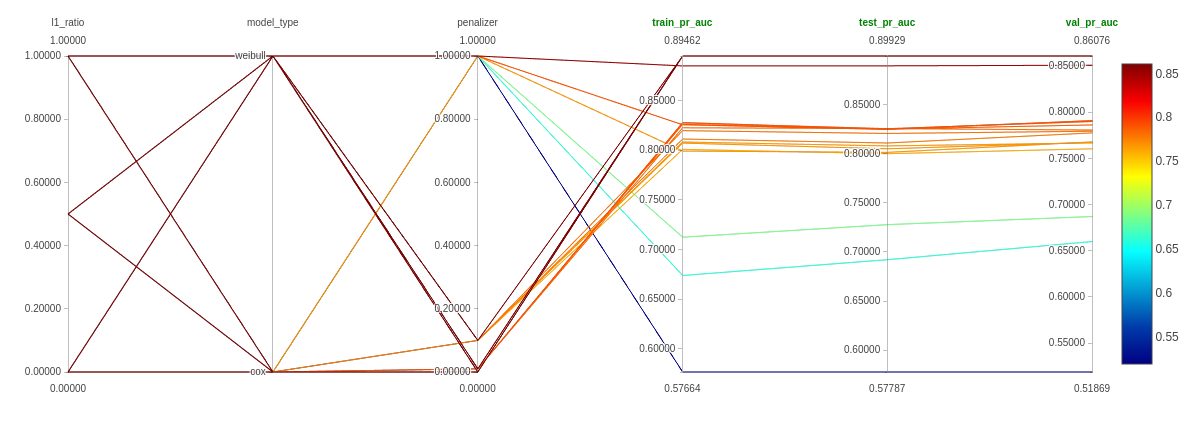
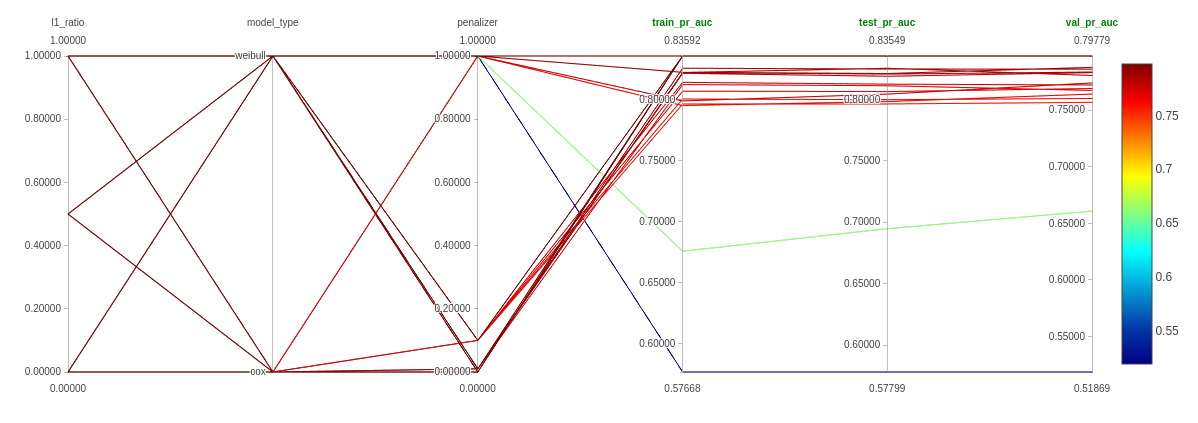

## Choose Production Model

Based on the tuning experiment, two best models so far for production are:
- weibull__h30__p0.01__l10.0

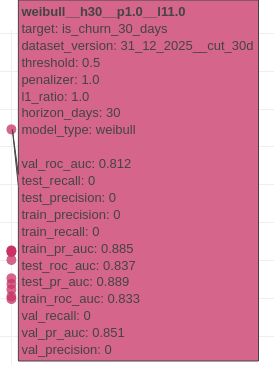

I will promote Weibull to production because its performance technically slightly better than other models.

In [378]:
promote_to_production("7bf52a14feb9409882741249fc0046de")

In [379]:
model, metadata = load_survival_analysis_model()

## Inference

On inference: Have to import the transformed_survival_df.csv for fast lookup.

In [381]:
predict_user_survival(
    customer_id="C00013",
    survival_df=X_train_survival_transformed,
    model=model,
)

{'survival_curve': [{'day': 30, 'prob': 0.9964},
  {'day': 60, 'prob': 0.9742},
  {'day': 90, 'prob': 0.9199}],
 'expected_remaining_lifetime': 190.71}